Corrected Coefficients:
C3 = 10.616493425609905
C2 = 30.2290549754126
C1 = 4337.182261291385
R^2 Score: 0.3605
Mean Absolute Error (MAE): 20007.65 W

Calculated Parameters:
Cd (Drag Coefficient) = 0.4203
V_wind_avg (Average Wind Speed) = -1.4237 m/s
Cr (Rolling Resistance Coefficient) = 0.0204


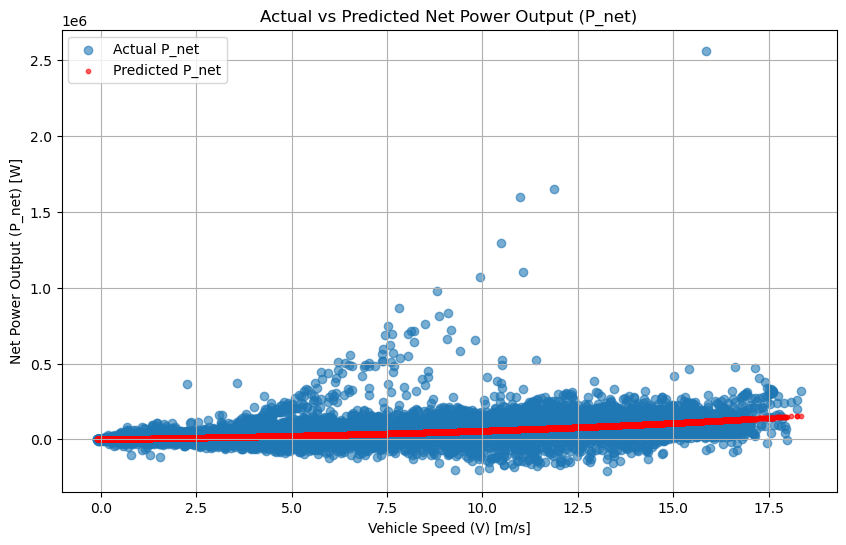

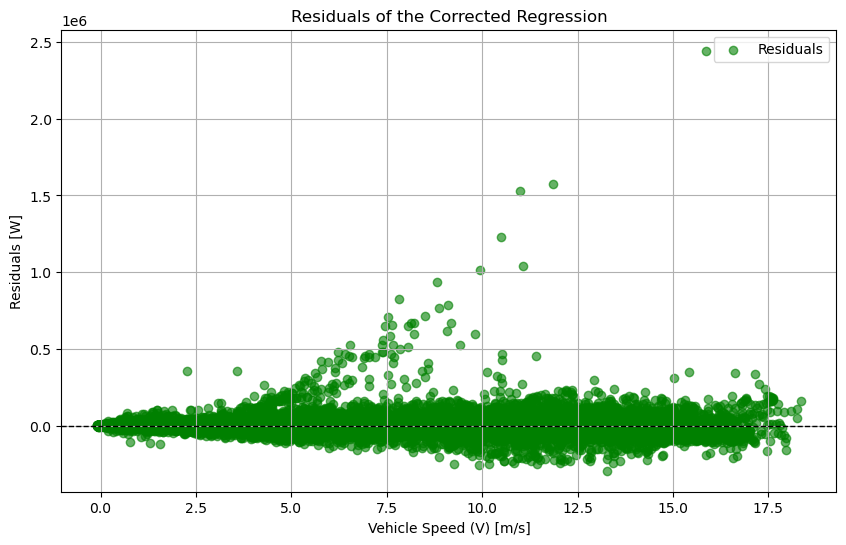

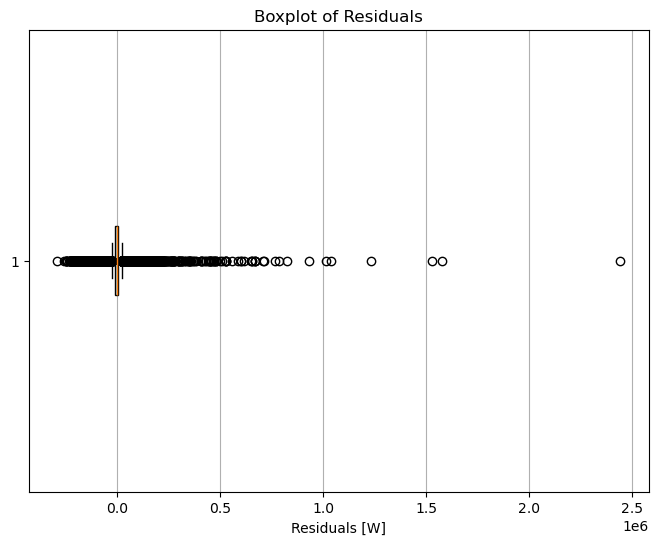

In [3]:
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error

import numpy as np

import matplotlib.pyplot as plt
 
# Load the provided Excel dataset

file_path = 'merged_data.xlsx'  # Replace with the correct file path

data = pd.ExcelFile(file_path)

filtered_data = data.parse('Sheet1')  # Assuming the dataset is in the first sheet
 
# Constants

rho = 1.225  # Air density in kg/m^3

g = 9.81  # Gravitational acceleration in m/s^2
 
# Extract relevant variables

V = filtered_data['WheelBasedVehicleSpeed'].values  # Vehicle speed

P_out = filtered_data['P_out'].values  # Output power

dynamic_mass = filtered_data['total_weight'].fillna(filtered_data['total_weight'].mean()).values  # Vehicle mass

slope = filtered_data['slope'].fillna(0).values  # Road slope (assume in radians)

V_wind = filtered_data['average_effective_wind_speed_m/s'].fillna(0).values  # Wind speed
 
# Calculate acceleration from velocity (finite differences)

acceleration = np.gradient(V, edge_order=2)  # Numerical derivative of velocity
 
# Calculate P_conservative components based on the formula

P_kinetic = dynamic_mass * V * acceleration  # m * v * a

P_gravitational = dynamic_mass * g * V * slope  # m * g * v * alpha
 
# Total P_conservative

P_conservative_corrected = P_kinetic + P_gravitational
 
# Calculate P_net

P_net_corrected = P_out - P_conservative_corrected
 
# Prepare regression terms for polynomial regression

X = np.column_stack((V**3, V**2, V))  # Polynomial terms
 
# Perform regression with the corrected P_net

regression_model_corrected = LinearRegression()

regression_model_corrected.fit(X, P_net_corrected)
 
# Extract corrected coefficients

C3_corrected, C2_corrected, C1_corrected = regression_model_corrected.coef_
 
# Calculate the parameters

A_avg = filtered_data['Average_Effective_Surface_Area_m2'].mean()  # Average effective surface area
 
# Calculate Cd

Cd = (2 * C3_corrected) / (rho * A_avg)
 
# Calculate V_wind (average wind speed)

V_wind_avg = -C2_corrected / (Cd * rho * A_avg)
 
# Calculate Cr

Cr = (C1_corrected - (0.5 * Cd * rho * A_avg * V_wind_avg**2)) / (dynamic_mass.mean() * g)
 
# Evaluate regression performance

r2_corrected = r2_score(P_net_corrected, regression_model_corrected.predict(X))

mae_corrected = mean_absolute_error(P_net_corrected, regression_model_corrected.predict(X))
 
# Output results

print("Corrected Coefficients:")

print(f"C3 = {C3_corrected}")

print(f"C2 = {C2_corrected}")

print(f"C1 = {C1_corrected}")

print(f"R^2 Score: {r2_corrected:.4f}")

print(f"Mean Absolute Error (MAE): {mae_corrected:.2f} W")

print("\nCalculated Parameters:")

print(f"Cd (Drag Coefficient) = {Cd:.4f}")

print(f"V_wind_avg (Average Wind Speed) = {V_wind_avg:.4f} m/s")

print(f"Cr (Rolling Resistance Coefficient) = {Cr:.4f}")
 
# Plot Actual vs Predicted P_net

plt.figure(figsize=(10, 6))

plt.scatter(V, P_net_corrected, label='Actual P_net', alpha=0.6)

plt.scatter(V, regression_model_corrected.predict(X), label='Predicted P_net', alpha=0.6, color='red', s=10)

plt.title('Actual vs Predicted Net Power Output (P_net)')

plt.xlabel('Vehicle Speed (V) [m/s]')

plt.ylabel('Net Power Output (P_net) [W]')

plt.legend()

plt.grid(True)

plt.show()
 
# Residuals Plot

residuals_corrected = P_net_corrected - regression_model_corrected.predict(X)

plt.figure(figsize=(10, 6))

plt.scatter(V, residuals_corrected, label='Residuals', color='green', alpha=0.6)

plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Residuals of the Corrected Regression')

plt.xlabel('Vehicle Speed (V) [m/s]')

plt.ylabel('Residuals [W]')

plt.legend()

plt.grid(True)

plt.show()
 
# Boxplot of Residuals

plt.figure(figsize=(8, 6))

plt.boxplot(residuals_corrected, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.title('Boxplot of Residuals')

plt.xlabel('Residuals [W]')

plt.grid(True, axis='x')

plt.show()

 